<a href="https://colab.research.google.com/github/abeSanchez/Machine-Learning-UCF/blob/master/homework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Homework 1
## Abraham Sanchez

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import models
from keras import layers
%matplotlib inline

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


### Functions for activation, loss and gradients

In [0]:
def sigmoid(z):
  return 1.0 / (1.0 + np.exp(-z))

def sigmoid_prime(z):
  sz = sigmoid(z)
  return sz * (1 - sz)

def se_loss(a, y):
  return 0.5 * (a - y) ** 2

def se_gradient(a, x, y):
  return (a - y) * sigmoid_prime(a) * x

def bce_loss(a, y):
  return -y * np.log10(a + 1e-9) - (1 - y) * np.log10(1 - a + 1e-9)

def bce_gradient(a, x, y):
  return (a - y) * x

def cce_loss(a, y):
  return -np.sum(y * np.log10(a + 1e-9))

def cce_gradient(a, x, y):
  return (a - y) * x

def softmax(z):
  exps = np.exp(z - np.max(z))
  return exps / np.sum(exps)

### MNIST data preprocessing

In [0]:
# Flatten images and apply feature scaling
flat_x_train = x_train.reshape(60000, 28 * 28) / 255
flat_x_test = x_test.reshape(10000, 28 * 28) / 255

In [0]:
# Create new array for labels for each digit
y_train_single_digit = {}
y_test_single_digit = {}

for i in range(10):
  y_train_single_digit[i] = y_train == i
  y_train_single_digit[i] = y_train_single_digit[i].astype(int)
  y_test_single_digit[i] = y_test == i
  y_test_single_digit[i] = y_test_single_digit[i].astype(int)

In [0]:
# One hot encoding for labels
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

### Setting up weights for problems 1 - 3

In [0]:
# Create dictionaries for storing the weights
w_mse = {}
w_bce = {}

for i in range(10):
  w_mse[i] = (np.random.rand(28 * 28, 1).reshape((784,)) - 0.5, np.random.rand(1))
  w_bce[i] = (np.random.rand(28 * 28, 1).reshape((784,)) - 0.5, np.random.rand(1))
  
w_cce = np.random.rand(28 * 28 * 10, 1).reshape((784,10)) - 0.5 
w_cce_b = np.random.rand(10, 1)

# Problem 1
## Using logistic regression with mean squared error loss

### Training the classifiers

In [0]:
epochs = 20
lr = 0.05
batch_size = 32
accuracy = []
loss = []

for digit in range(10):
  accuracy.append([])
  loss.append([])
  
  for epoch in range(epochs):
    shuffled_indices = np.random.permutation(len(flat_x_train))
    flat_x_train_shuffled = flat_x_train[shuffled_indices]
    y_train_single_digit_shuffled = y_train_single_digit[digit][shuffled_indices]
    
    correct = 0
    loss_epoch = 0
    
    for i in range(0, len(flat_x_train), batch_size):
      xi = flat_x_train_shuffled[i:i+batch_size]
      yi = y_train_single_digit_shuffled[i:i+batch_size].reshape(32,1)
      
      z = xi.dot(w_mse[digit][0]) + w_mse[digit][1]
      a = sigmoid(z).reshape(32,1)
      
      correct += np.sum(np.round(a).astype(int) == yi)
      loss_epoch += np.sum(se_loss(a, yi))
      
      gradient = np.sum(se_gradient(a, xi, yi), axis=0) / batch_size
      gradient_b = np.sum(se_gradient(a, 1, yi), axis=0) / batch_size
      w_mse[digit] = (w_mse[digit][0] - lr * gradient, w_mse[digit][1] - lr * gradient_b)
    
    accuracy_epoch = correct / len(flat_x_train)
    loss_epoch /= len(flat_x_train)
    
    accuracy[digit].append(accuracy_epoch)
    loss[digit].append(loss_epoch)

### Visualizing training accuracy and loss

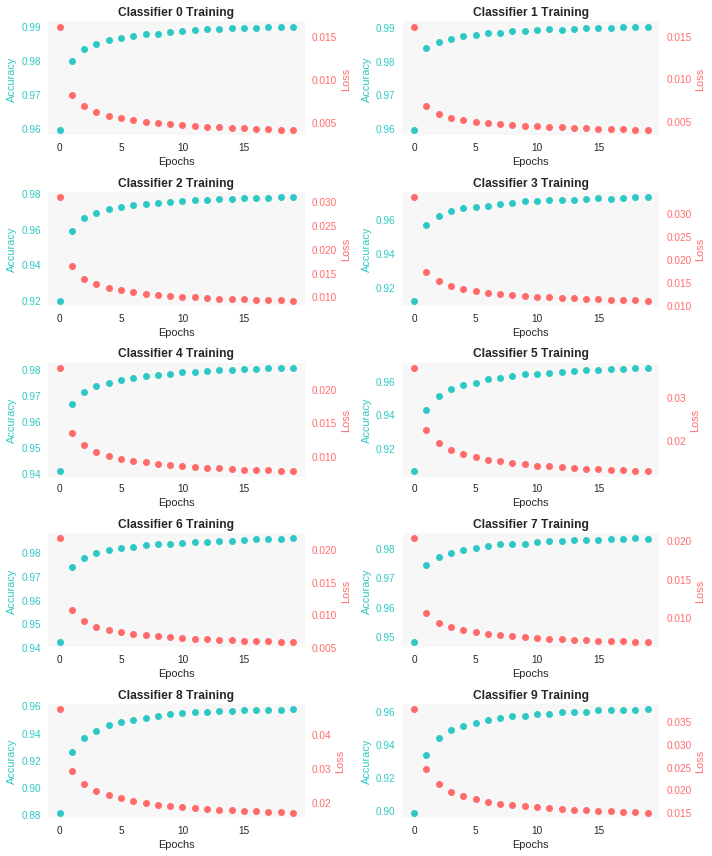

In [0]:
training_plots = {}

plt.figure(figsize=(10,12))

for digit in range(10):
  training_plots[digit] = plt.subplot2grid((5, 2), (int(digit / 2), digit % 2), rowspan=1, colspan=1)

for digit in range(10):
  ax1 = training_plots[digit]
  ax1.set_title("Classifier " + str(digit) + " Training", fontweight='bold')
  ax1.set_xlabel('Epochs')
  ax1.plot(range(len(accuracy[digit])), accuracy[digit], '#2EC9C4', ls=' ', marker='o')
  ax1.set_ylabel('Accuracy', color='#2EC9C4')
  ax1.tick_params('y', colors='#2EC9C4')
  ax1.grid(False)
  ax1.set_facecolor('#F7F7F7')
  
  ax2 = ax1.twinx()
  ax2.plot(range(len(loss[digit])), loss[digit], '#FF6B6B', ls=' ', marker='o')
  ax2.set_ylabel('Loss', color='#FF6B6B')
  ax2.tick_params('y', colors='#FF6B6B')
  ax2.grid(False)
  
plt.tight_layout()

### Testing the classifiers on test data

In [0]:
for digit in range(10):
  loss = 0
  correct = 0

  for example in range(len(flat_x_test)):
      z = flat_x_test[example].dot(w_mse[digit][0]) + w_mse[digit][1]
      a = sigmoid(z)
      prediction = int(round(a[0]))
      loss += se_loss(prediction, y_test_single_digit[digit][example])
      correct += 1 if y_test_single_digit[digit][example] == prediction else 0
        
  loss /= len(flat_x_test)
  accuracy = correct / len(flat_x_test)
  print("Classifier " + str(digit) + " | loss: " + str(loss) + " - accuracy: " + str(accuracy))

Classifier 0 | loss: 0.0043 - accuracy: 0.9914
Classifier 1 | loss: 0.00365 - accuracy: 0.9927
Classifier 2 | loss: 0.01045 - accuracy: 0.9791
Classifier 3 | loss: 0.01205 - accuracy: 0.9759
Classifier 4 | loss: 0.0104 - accuracy: 0.9792
Classifier 5 | loss: 0.01455 - accuracy: 0.9709
Classifier 6 | loss: 0.0073 - accuracy: 0.9854
Classifier 7 | loss: 0.00775 - accuracy: 0.9845
Classifier 8 | loss: 0.0202 - accuracy: 0.9596
Classifier 9 | loss: 0.0182 - accuracy: 0.9636


### Using all classifiers to perform digit classification on test data

In [0]:
correct = 0

for example in range(len(flat_x_test)):
  y_predict = np.array([])  
  
  for classifier in range(10):
    z = flat_x_test[example].dot(w_mse[classifier][0]) + w_mse[classifier][1]
    a = sigmoid(z)
    y_predict = np.append(y_predict, a)
    
  correct += 1 if np.argmax(y_predict) == y_test[example] else 0

    
print("Accuracy on test data : " + str(correct / len(flat_x_test)))

Accuracy on test data : 0.9124


# Problem 2
## Using logistic regression with binary cross entropy loss

### Training the classifiers

In [0]:
epochs = 20
lr = 0.05
batch_size = 32
accuracy = []
loss = []

for digit in range(10):
  accuracy.append([])
  loss.append([])
  
  for epoch in range(epochs):
    shuffled_indices = np.random.permutation(len(flat_x_train))
    flat_x_train_shuffled = flat_x_train[shuffled_indices]
    y_train_single_digit_shuffled = y_train_single_digit[digit][shuffled_indices]
    
    correct = 0
    loss_epoch = 0
    
    for i in range(0, len(flat_x_train), batch_size):
      xi = flat_x_train_shuffled[i:i+batch_size]
      yi = y_train_single_digit_shuffled[i:i+batch_size].reshape(32,1)
      
      z = xi.dot(w_bce[digit][0]) + w_bce[digit][1]
      a = sigmoid(z).reshape(32,1)
      
      correct += np.sum(np.round(a).astype(int) == yi)
      loss_epoch += np.sum(bce_loss(a, yi))
      
      gradient = np.sum(bce_gradient(a, xi, yi), axis=0) / batch_size
      gradient_b = np.sum(bce_gradient(a, 1, yi), axis=0) / batch_size
      w_bce[digit] = (w_bce[digit][0] - lr * gradient, w_bce[digit][1] - lr * gradient_b)
      
    accuracy_epoch = correct / len(flat_x_train)
    loss_epoch /= len(flat_x_train)
    
    accuracy[digit].append(accuracy_epoch)
    loss[digit].append(loss_epoch)

### Visualizing training accuracy and loss

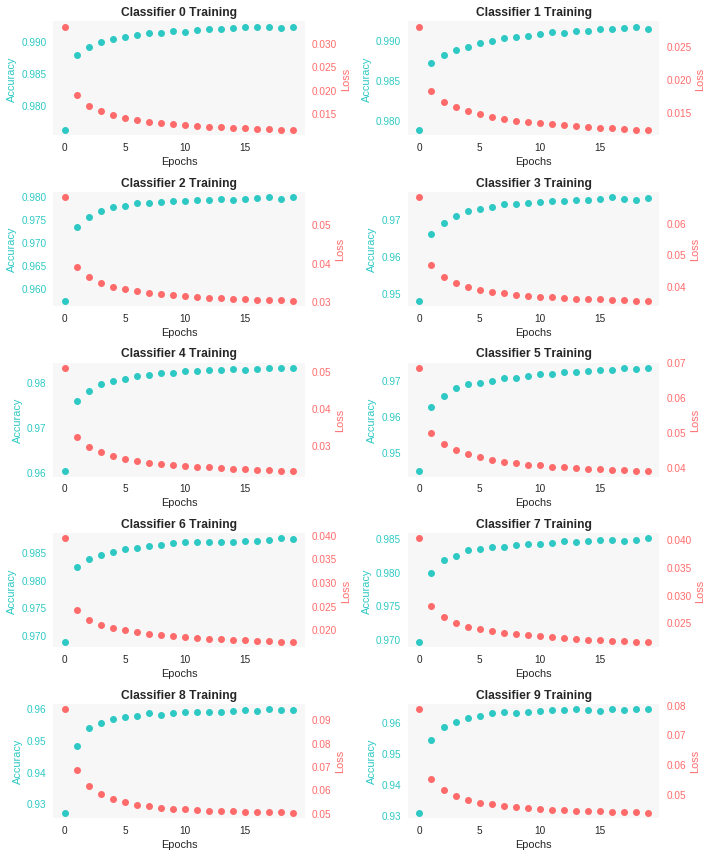

In [8]:
training_plots = {}

plt.figure(figsize=(10,12))

for digit in range(10):
  training_plots[digit] = plt.subplot2grid((5, 2), (int(digit / 2), digit % 2), rowspan=1, colspan=1)

for digit in range(10):
  ax1 = training_plots[digit]
  ax1.set_title("Classifier " + str(digit) + " Training", fontweight='bold')
  ax1.set_xlabel('Epochs')
  ax1.plot(range(len(accuracy[digit])), accuracy[digit], '#2EC9C4', ls=' ', marker='o')
  ax1.set_ylabel('Accuracy', color='#2EC9C4')
  ax1.tick_params('y', colors='#2EC9C4')
  ax1.grid(False)
  ax1.set_facecolor('#F7F7F7')
  
  ax2 = ax1.twinx()
  ax2.plot(range(len(loss[digit])), loss[digit], '#FF6B6B', ls=' ', marker='o')
  ax2.set_ylabel('Loss', color='#FF6B6B')
  ax2.tick_params('y', colors='#FF6B6B')
  ax2.grid(False)
  
plt.tight_layout()

### Testing the classifiers on test data

In [9]:
for digit in range(10):
  loss = 0
  correct = 0
  
  for example in range(len(flat_x_test)):
      z = flat_x_test[example].dot(w_bce[digit][0]) + w_bce[digit][1]
      a = sigmoid(z)
      prediction = int(round(a[0]))
      loss += bce_loss(prediction, y_test_single_digit[digit][example])
      correct += 1 if y_test_single_digit[digit][example] == prediction else 0
        
  loss /= len(flat_x_test)
  accuracy = correct / len(flat_x_test)
  print("Classifier " + str(digit) + " | loss: " + str(loss) + " - accuracy: " + str(accuracy))

Classifier 0 | loss: 0.07469999956931857 - accuracy: 0.9917
Classifier 1 | loss: 0.05759999956849324 - accuracy: 0.9936
Classifier 2 | loss: 0.18629999957470536 - accuracy: 0.9793
Classifier 3 | loss: 0.20069999957540008 - accuracy: 0.9777
Classifier 4 | loss: 0.16469999957366271 - accuracy: 0.9817
Classifier 5 | loss: 0.21779999957622503 - accuracy: 0.9758
Classifier 6 | loss: 0.11609999957131727 - accuracy: 0.9871
Classifier 7 | loss: 0.13229999957209942 - accuracy: 0.9853
Classifier 8 | loss: 0.3500999995826093 - accuracy: 0.9611
Classifier 9 | loss: 0.3050999995804378 - accuracy: 0.9661


### Using all classifiers to perform digit classification on test data

In [10]:
correct = 0

for example in range(len(flat_x_test)):
  y_predict = np.array([])  
  
  for classifier in range(10):
    z = flat_x_test[example].dot(w_bce[classifier][0]) + w_bce[classifier][1]
    a = sigmoid(z)
    y_predict = np.append(y_predict, a)
    
  correct += 1 if np.argmax(y_predict) == y_test[example] else 0
    
print("Accuracy on test data : " + str(correct / len(flat_x_test)))

Accuracy on test data : 0.9163


# Problem 3
## Using softmax and categorical cross entropy loss

### Training the network

In [0]:
epochs = 20
lr = 0.01
batch_size = 32
accuracy = []
loss = []

for epoch in range(epochs):
  shuffled_indices = np.random.permutation(len(flat_x_train))
  flat_x_train_shuffled = flat_x_train[shuffled_indices]
  y_train_shuffled = y_train_cat[shuffled_indices]
  loss_epoch = 0
  correct = 0
  
  for i in range(0, len(flat_x_train), batch_size):
    xi = flat_x_train_shuffled[i:i+batch_size]
    yi = y_train_shuffled[i:i+batch_size]
      
    for j in range(batch_size):
      z = xi[j].dot(w_cce).reshape(10,1) + w_cce_b.reshape(10,1)
      a = softmax(z)
      
      loss_epoch += cce_loss(a, yi[j].reshape(10,1))
      correct += 1 if np.argmax(a) == np.argmax(yi[j]) else 0
      
      gradient_j = cce_gradient(a, xi[j], yi[j].reshape(10,1)) 
      gradient_b_j = cce_gradient(a, 1, yi[j].reshape(10,1)) 
      
      gradient = gradient_j if j == 0 else gradient + gradient_j
      gradient_b = gradient_b if j == 0 else gradient_b + gradient_b_j
    
    gradient = gradient / batch_size
    gradient_b = gradient_b / batch_size

    w_cce = w_cce - lr * gradient.T
    w_cce_b = w_cce_b - lr * gradient_b
    
  loss.append(loss_epoch / len(flat_x_train))
  accuracy.append(correct / len(flat_x_train))

### Visualizing training accuracy and loss

<Figure size 720x864 with 0 Axes>

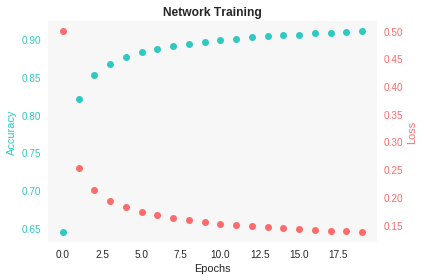

In [0]:
training_plots = {}

plt.figure(figsize=(10,12))

fig, ax1 = plt.subplots()
ax1.set_title("Network Training", fontweight='bold')
ax1.set_xlabel('Epochs')
ax1.plot(range(len(accuracy)), accuracy, '#2EC9C4', ls=' ', marker='o')
ax1.set_ylabel('Accuracy', color='#2EC9C4')
ax1.tick_params('y', colors='#2EC9C4')
ax1.grid(False)
ax1.set_facecolor('#F7F7F7')

ax2 = ax1.twinx()
ax2.plot(range(len(loss)), loss, '#FF6B6B', ls=' ', marker='o')
ax2.set_ylabel('Loss', color='#FF6B6B')
ax2.tick_params('y', colors='#FF6B6B')
ax2.grid(False)
  
plt.tight_layout()

### Testing the network on test data

In [0]:
loss = 0
correct = 0

for example in range(len(flat_x_test)):
  z = flat_x_test[example].dot(w_cce).reshape(10,1) + w_cce_b.reshape(10,1)
  y_predict = softmax(z)
  correct += 1 if np.argmax(y_predict) == y_test[example] else 0
  loss += cce_loss(y_predict, y_test_cat[example].reshape(10,1))

loss /= len(flat_x_test)
accuracy = correct / len(flat_x_test)
print("loss: " + str(loss) + " - accuracy: " + str(accuracy))

loss: 0.13311769081136274 - accuracy: 0.9108


# Problem 4
## Reimplementing the network from Problem 3 entirely in Keras

### Setting up the network architecture

In [0]:
network = models.Sequential()
network.add(layers.Dense(10, activation='softmax', input_shape=(28 * 28,)))
network.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


### Compiling the network

In [0]:
network.compile(optimizer='sgd',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

### Training the network

In [0]:
epochs = 10
network.fit(flat_x_train, 
            y_train_cat, 
            epochs=epochs, 
            batch_size=32, 
            validation_data=(flat_x_test, y_test_cat))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 9s 153us/step - loss: 0.7809 - acc: 0.8145 - val_loss: 0.4785 - val_acc: 0.8799
Epoch 2/10
60000/60000 [==============================] - 6s 108us/step - loss: 0.4565 - acc: 0.8806 - val_loss: 0.3980 - val_acc: 0.8955
Epoch 3/10
60000/60000 [==============================] - 6s 105us/step - loss: 0.4034 - acc: 0.8916 - val_loss: 0.3665 - val_acc: 0.9023
Epoch 4/10
60000/60000 [==============================] - 6s 105us/step - loss: 0.3769 - acc: 0.8969 - val_loss: 0.3470 - val_acc: 0.9060
Epoch 5/10
60000/60000 [==============================] - 6s 105us/step - loss: 0.3600 - acc: 0.9008 - val_loss: 0.3349 - val_acc: 0.9090
Epoch 6/10
60000/60000 [==============================] - 6s 105us/step - loss: 0.3483 - acc: 0.9032 - val_loss: 0.3261 - val_acc: 0.9114
Epoch 7/10
60000/60000 [==============================] - 6s 105us/step - 

# Problem 5
## Extending the network from Problem 4 by adding new features

### Methods for extracting features

In [0]:
def round_grey_values(original_image):
  return np.round(original_image / 255).astype(int)

# Get number of white regions for an image (Threshold = 100)
def num_white_regions(original_image):
  image = np.copy(original_image)
  num_regions = 0
  
  for i in range(len(image)):
    for j in range(len(image[i])):
      if image[i,j] == 1:
        num_regions += 1
        visit_region(image, i, j)
        
  return num_regions

# num_white_regions() helper function
def visit_region(image, i, j):
  if (i < 0 or j < 0 or i >= len(image)
      or j >= len(image[0]) or image[i,j] == 0):
    return
  
  image[i,j] = 0
  visit_region(image, i + 1, j)
  visit_region(image, i - 1, j)
  visit_region(image, i, j + 1)
  visit_region(image, i, j - 1)

def digit_width(image):
  min_x = len(image)
  max_x = 0
  
  for i in range(len(image)):
    min_x = min(np.argmax(image[i]), min_x)
    max_x = max(np.argmax(np.flip(image[i], 0)), max_x)
  
  return max_x - min_x

def digit_height(image):
  return digit_width(image.T)

def digit_area(image):
  return np.sum(image)

### Extract number of white regions from image

In [0]:
num_regions_train = []
num_regions_test = []

for image in range(len(x_train)):
  num_regions_train.append(num_white_regions(x_train[image]))
  
for image in range(len(x_test)):
  num_regions_test.append(num_white_regions(x_test[image]))
  
num_regions_train = np.array(num_regions_train)
num_regions_test = np.array(num_regions_test)

### Extract white regions, digit height, width and area from image

In [0]:
digit_width_train = []
digit_width_test = []
digit_height_train = []
digit_height_test = []
digit_area_train = []
digit_area_test = []

for image in range(len(x_train)):
  digit_width_train.append(digit_width(x_train[image]))
  digit_height_train.append(digit_height(x_train[image]))
  digit_area_train.append(digit_area(x_train[image]))
  
for image in range(len(x_test)):
  digit_width_test.append(digit_width(x_test[image]))
  digit_height_test.append(digit_height(x_test[image]))
  digit_area_test.append(digit_area(x_test[image]))
  
digit_width_train = np.array(digit_width_train)
digit_width_test = np.array(digit_width_test)

digit_height_train = np.array(digit_height_train)
digit_height_test = np.array(digit_height_test)

digit_area_train = np.array(digit_area_train)
digit_area_test = np.array(digit_area_test)

### Feature scale engineered data

In [0]:
# Find max and mins of train and test
num_regions_min = min(np.min(num_regions_train), np.min(num_regions_test))
num_regions_max = max(np.max(num_regions_train), np.max(num_regions_test))

digit_width_min = min(np.min(digit_width_train), np.min(digit_width_test))
digit_width_max = max(np.max(digit_width_train), np.max(digit_width_test))

digit_height_min = min(np.min(digit_height_train), np.min(digit_height_test))
digit_height_max = max(np.max(digit_height_train), np.max(digit_height_test))

digit_area_min = min(np.min(digit_area_train), np.min(digit_area_test))
digit_area_max = max(np.max(digit_area_train), np.max(digit_area_test))


# Use found max and mins to feature scale
num_regions_train = num_regions_train - num_regions_min
num_regions_train = num_regions_train / num_regions_max

num_regions_test = num_regions_test - num_regions_min
num_regions_test = num_regions_test / num_regions_max

digit_width_train = digit_width_train - digit_width_min
digit_width_train = digit_width_train / digit_width_max

digit_width_test = digit_width_test - digit_height_min
digit_width_test = digit_width_test / digit_height_max

digit_height_train = digit_height_train - digit_height_min
digit_height_train = digit_height_train / digit_height_max

digit_height_test = digit_height_test - digit_height_min
digit_height_test = digit_height_test / digit_height_max

digit_area_train = digit_area_train - digit_area_min
digit_area_train = digit_area_train / digit_area_max

digit_area_test = digit_area_test - digit_area_min
digit_area_test = digit_area_test / digit_area_max

### Stack flattened image on top of engineered features

In [0]:
engineered_features_train = np.array([num_regions_train, 
                                      digit_width_train, 
                                      digit_height_train, 
                                      digit_area_train])
engineered_features_test = np.array([num_regions_test, 
                                     digit_width_test, 
                                     digit_height_test, 
                                     digit_area_test])

In [0]:
flat_x_train2 = []
flat_x_test2 = []

for i in range(len(flat_x_train)):
  flat_x_train2.append(np.append(flat_x_train[i], engineered_features_train[:,i]))
  
for i in range(len(flat_x_test)):
  flat_x_test2.append(np.append(flat_x_test[i], engineered_features_test[:,i]))
  
flat_x_train2 = np.array(flat_x_train2)
flat_x_test2 = np.array(flat_x_test2)

### Setting up the network architecture

In [0]:
network2 = models.Sequential()
network2.add(layers.Dense(10, activation='softmax', input_shape=(28 * 28 + 4,)))
network2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                7890      
Total params: 7,890
Trainable params: 7,890
Non-trainable params: 0
_________________________________________________________________


### Compiling the network

In [0]:
network2.compile(optimizer='sgd',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

### Training the network

In [0]:
epochs = 10
network2.fit(flat_x_train2, 
            y_train_cat, 
            epochs=epochs, 
            batch_size=32, 
            validation_data=(flat_x_test2, y_test_cat))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 113us/step - loss: 0.7810 - acc: 0.8152 - val_loss: 0.4762 - val_acc: 0.8845
Epoch 2/10
60000/60000 [==============================] - 6s 104us/step - loss: 0.4533 - acc: 0.8816 - val_loss: 0.3961 - val_acc: 0.8981
Epoch 3/10
60000/60000 [==============================] - 6s 105us/step - loss: 0.4003 - acc: 0.8925 - val_loss: 0.3635 - val_acc: 0.9029
Epoch 4/10
60000/60000 [==============================] - 6s 104us/step - loss: 0.3740 - acc: 0.8973 - val_loss: 0.3451 - val_acc: 0.9086
Epoch 5/10
60000/60000 [==============================] - 6s 105us/step - loss: 0.3574 - acc: 0.9013 - val_loss: 0.3337 - val_acc: 0.9102
Epoch 6/10
60000/60000 [==============================] - 6s 104us/step - loss: 0.3457 - acc: 0.9042 - val_loss: 0.3241 - val_acc: 0.9123
Epoch 7/10
60000/60000 [==============================] - 6s 104us/step - loss: 0.3369 - acc: 0.9061 - val_loss: 0.3171 - 